Epoch: 1, Cost: 290.031
Epoch: 2, Cost: 253.809
Epoch: 3, Cost: 248.719
Epoch: 4, Cost: 246.539
Epoch: 5, Cost: 245.112
Epoch: 6, Cost: 244.076
Epoch: 7, Cost: 243.299
Epoch: 8, Cost: 242.654
Epoch: 9, Cost: nan
Epoch: 10, Cost: nan


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


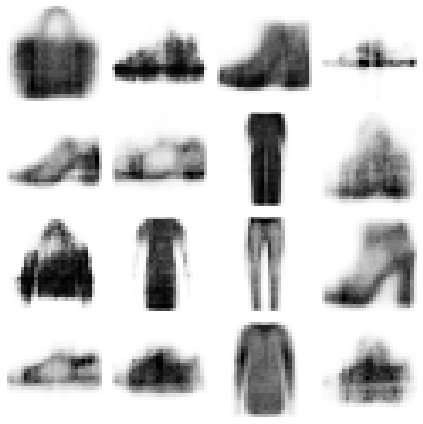

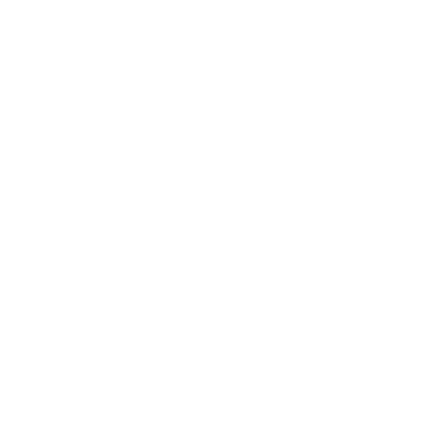

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from pathlib import Path


class VAE(nn.Module):
    '''
    Simple Variational Autoencoder
    '''
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = Encoder(device=device)
        self.decoder = Decoder(device=device)

    def forward(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)

        return y

    def reparameterize(self, mean, var):
        eps = torch.randn(mean.size()).to(self.device)
        z = mean + torch.sqrt(var) * eps
        return z

    def lower_bound(self, x):
        mean, var = self.encoder(x)
        kl = - 1/2 * torch.mean(torch.sum(1
                                          + torch.log(var)
                                          - mean**2
                                          - var, dim=1))
        z = self.reparameterize(mean, var)
        y = self.decoder(z)

        reconst = torch.mean(torch.sum(x * torch.log(y)
                                       + (1 - x) * torch.log(1 - y), dim=1))

        return reconst - kl


class Encoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 200)
        self.l2 = nn.Linear(200, 200)
        self.l_mean = nn.Linear(200, 10)
        self.l_var = nn.Linear(200, 10)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        h = torch.relu(h)

        mean = self.l_mean(h)
        var = F.softplus(self.l_var(h))

        return mean, var


class Decoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(10, 200)
        self.l2 = nn.Linear(200, 200)
        self.out = nn.Linear(200, 784)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        h = torch.relu(h)
        h = self.out(h)
        y = torch.sigmoid(h)

        return y


if __name__ == '__main__':
    np.random.seed(1234)
    torch.manual_seed(1234)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    os.mkdir('output')

    def compute_loss(x):
        return -1 * criterion(x)

    def train_step(x):
        model.train()
        loss = compute_loss(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss

    def generate(batch_size=10):
        model.eval()
        z = gen_noise(batch_size)
        gen = model.decoder(z)
        gen = gen.view(-1, 28, 28)

        return gen

    def gen_noise(batch_size):
        return torch.empty(batch_size, 10).normal_().to(device)

    '''
    Load data
    '''
    root = os.path.join(Path().resolve(),
                        '..', 'data', 'fashion_mnist')
    transform = transforms.Compose([transforms.ToTensor(),
                                    lambda x: x.view(-1)])
    mnist_train = \
        torchvision.datasets.FashionMNIST(root=root,
                                          download=True,
                                          train=True,
                                          transform=transform)
    train_dataloader = DataLoader(mnist_train,
                                  batch_size=100,
                                  shuffle=True)

    '''
    Build model
    '''
    model = VAE(device=device).to(device)
    criterion = model.lower_bound
    optimizer = optimizers.Adam(model.parameters())

    '''
    Train model
    '''
    epochs = 10
    out_path = os.path.join(Path().resolve(),
                            'output')

    for epoch in range(epochs):
        train_loss = 0.

        for (x, _) in train_dataloader:
            x = x.to(device)
            loss = train_step(x)

            train_loss += loss.item()

        train_loss /= len(train_dataloader)

        print('Epoch: {}, Cost: {:.3f}'.format(
            epoch+1,
            train_loss
        ))

        if epoch % 5 == 4 or epoch == epochs - 1:
            images = generate(batch_size=16)
            images = images.squeeze().detach().cpu().numpy()
            plt.figure(figsize=(6, 6))
            for i, image in enumerate(images):
                plt.subplot(4, 4, i+1)
                plt.imshow(image, cmap='binary')
                plt.axis('off')
            plt.tight_layout()
            # plt.show()
            template = '{}/vae_fashion_mnist_epoch_{:0>4}.png'
            plt.savefig(template.format(out_path, epoch+1), dpi=300)